# Case Study

## Amadeus API

In [2]:
## Let's first use an API to get the data
import os
import json
import requests
import time 
import datetime
from dotenv import load_dotenv

## Load API keys}
load_dotenv('/media/api.env')

## Extract API keys
api_key = os.getenv("API_KEY")
api_secret = os.getenv("API_SECRET")

print(type(api_key))

<class 'str'>


In [1]:
!pip install amadeus

  Preparing metadata (setup.py) ... done
  Created wheel for amadeus: filename=amadeus-6.0.1-py2.py3-none-any.whl size=73773 sha256=1edd0df6ecf48f08e8877b581aa36398f67198586b696959549d7abb13a062e7
  Stored in directory: /root/.cache/pip/wheels/8c/c0/62/e35d1e0bd9b78be13e798fb02e6f110cbf8a5587ecc8021d5d
Successfully built amadeus


In [3]:
!pip install python-dotenv

In [14]:
## Let's try to use the API - Using their documentation
from amadeus import Client, ResponseError

amadeus = Client(
    client_id = api_key,
    client_secret = api_secret
)

try:
    '''
    Find cheapest dates from Madrid to Munich
    '''
    flights = amadeus.shopping.flight_offers_search.get(originLocationCode='MAD', 
                                                        destinationLocationCode='MUC', departureDate='2022-11-01', adults=1).data
    print(flights)
except ResponseError as error:
    print(error)

[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'lastTicketingDate': '2022-05-25', 'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT2H30M', 'segments': [{'departure': {'iataCode': 'MAD', 'terminal': '2', 'at': '2022-11-01T07:10:00'}, 'arrival': {'iataCode': 'MUC', 'terminal': '1', 'at': '2022-11-01T09:40:00'}, 'carrierCode': 'UX', 'number': '1515', 'aircraft': {'code': '73H'}, 'operating': {'carrierCode': 'UX'}, 'duration': 'PT2H30M', 'id': '101', 'numberOfStops': 0, 'blacklistedInEU': False}]}], 'price': {'currency': 'EUR', 'total': '54.38', 'base': '36.00', 'fees': [{'amount': '0.00', 'type': 'SUPPLIER'}, {'amount': '0.00', 'type': 'TICKETING'}], 'grandTotal': '54.38', 'additionalServices': [{'amount': '30.00', 'type': 'CHECKED_BAGS'}]}, 'pricingOptions': {'fareType': ['PUBLISHED'], 'includedCheckedBagsOnly': False}, 'validatingAirlineCodes': ['UX'], 'travelerPricings': [{'travelerId': '1', 

That's a JSON file for you! long and hard to parse as a human. But we are prepared for it! Let's first use a batch process to pass over to a DataFrame

In [19]:
## Let's start by setting up the imports and the create the Spark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, from_json, lit
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType

spark = SparkSession\
        .builder\
        .appName("CaseStudy")\
        .master("local[*]")\
        .config("spark.ui.port","42229")\
        .getOrCreate()

In [16]:
raw_events = spark.createDataFrame(flights)

raw_events.show()

+---+------------------------+--------------------+-----------------+--------------+---------------------+------+--------------------+--------------------+------+--------------------+------------+----------------------+
| id|instantTicketingRequired|         itineraries|lastTicketingDate|nonHomogeneous|numberOfBookableSeats|oneWay|               price|      pricingOptions|source|    travelerPricings|        type|validatingAirlineCodes|
+---+------------------------+--------------------+-----------------+--------------+---------------------+------+--------------------+--------------------+------+--------------------+------------+----------------------+
|  1|                   false|[{duration -> PT2...|       2022-05-25|         false|                    9| false|{additionalServic...|{fareType -> [PUB...|   GDS|[{fareDetailsBySe...|flight-offer|                  [UX]|
|  2|                   false|[{duration -> PT2...|       2022-05-25|         false|                    9| false|{additi

Great! We have the data in a much better representation. However, we still have a lot of information that inside some of the columns. Let's continue our EDA

In [17]:
raw_events.take(1)

[Row(id='1', instantTicketingRequired=False, itineraries=[{'duration': 'PT2H30M', 'segments': '[{duration=PT2H30M, number=1515, blacklistedInEU=false, numberOfStops=0, arrival={at=2022-11-01T09:40:00, iataCode=MUC, terminal=1}, aircraft={code=73H}, carrierCode=UX, id=101, operating={carrierCode=UX}, departure={at=2022-11-01T07:10:00, iataCode=MAD, terminal=2}}]'}], lastTicketingDate='2022-05-25', nonHomogeneous=False, numberOfBookableSeats=9, oneWay=False, price={'additionalServices': '[{type=CHECKED_BAGS, amount=30.00}]', 'fees': '[{type=SUPPLIER, amount=0.00}, {type=TICKETING, amount=0.00}]', 'total': '54.38', 'currency': 'EUR', 'grandTotal': '54.38', 'base': '36.00'}, pricingOptions={'fareType': ['PUBLISHED'], 'includedCheckedBagsOnly': None}, source='GDS', travelerPricings=[{'fareDetailsBySegment': '[{includedCheckedBags={quantity=0}, fareBasis=NYYO5L, segmentId=101, cabin=ECONOMY, class=N, brandedFare=LITE}]', 'fareOption': 'STANDARD', 'travelerType': 'ADULT', 'price': '{total=54.

In [20]:
raw_events.select(raw_events['numberOfBookableSeats'], 
                  raw_events['price']['base'].alias("base_price"),
                  raw_events['price']['total'].alias('total_price'),
                  raw_events['price']['currency'].alias("currency"))\
            .withColumn('date', lit('2022-11-01')).show()

+---------------------+----------+-----------+--------+----------+
|numberOfBookableSeats|base_price|total_price|currency|      date|
+---------------------+----------+-----------+--------+----------+
|                    9|     36.00|      54.38|     EUR|2022-11-01|
|                    9|     36.00|      54.38|     EUR|2022-11-01|
|                    9|     49.00|      67.38|     EUR|2022-11-01|
|                    9|     49.00|      67.38|     EUR|2022-11-01|
|                    3|     21.00|      89.95|     EUR|2022-11-01|
|                    3|     21.00|      89.95|     EUR|2022-11-01|
|                    4|     56.00|     112.07|     EUR|2022-11-01|
|                    5|     56.00|     112.07|     EUR|2022-11-01|
|                    9|     42.00|     116.24|     EUR|2022-11-01|
|                    9|     42.00|     116.24|     EUR|2022-11-01|
|                    9|     42.00|     116.24|     EUR|2022-11-01|
|                    9|     42.00|     116.24|     EUR|2022-11

In [23]:
## Let's find the cheapest flight, suing Spark SQL
process_data = raw_events.select(raw_events['numberOfBookableSeats'], 
                  raw_events['price']['base'].alias("base_price"),
                  raw_events['price']['total'].alias('total_price'),
                  raw_events['price']['currency'].alias("currency"))\
            .withColumn('date', lit('2022-11-01'))

process_data.registerTempTable('flights')

spark.sql("""
    select 
        min(total_price) as cheap_flight, 
        date
    from flights
    group by
        date
""").show()

+------------+----------+
|cheap_flight|      date|
+------------+----------+
|      112.07|2022-11-01|
+------------+----------+



In [168]:
## Quick EDA is you want to do it in Plain Python
for f in flights:
    print(f['numberOfBookableSeats'], f['price']['total'], f['price']['base'], f['price']['currency'])

9 54.38 36.00 EUR
9 54.38 36.00 EUR
9 67.38 49.00 EUR
9 67.38 49.00 EUR
3 89.95 21.00 EUR
3 89.95 21.00 EUR
4 112.07 56.00 EUR
5 112.07 56.00 EUR
9 116.24 42.00 EUR
9 116.24 42.00 EUR
9 116.24 42.00 EUR
9 116.24 42.00 EUR
9 116.38 74.00 EUR
9 116.38 74.00 EUR
9 116.38 74.00 EUR
9 116.38 74.00 EUR
9 118.99 42.00 EUR
9 118.99 42.00 EUR
9 118.99 42.00 EUR
9 140.24 52.00 EUR
9 140.24 52.00 EUR
9 140.24 52.00 EUR
9 140.24 52.00 EUR
7 141.01 91.00 EUR
9 142.67 74.00 EUR
9 142.67 74.00 EUR
9 142.67 74.00 EUR
9 142.67 74.00 EUR
9 142.67 74.00 EUR
9 142.99 52.00 EUR
9 142.99 52.00 EUR
9 142.99 52.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 143.75 74.00 EUR
9 156.01 106.00 EUR
9 156.01 106.00 EUR
9 156.01 106.00 EUR
5 157.24 61.00 EUR
1 157.24 61.00 EUR
8 157.24 61.00 EUR
9 161.75 84.00 EUR
9 161.75 84.00 EUR
9 161.75 84.00 EUR
9 161.75 84.00 

## Expand to extract more information

With the previous analysis we have all the flights on a particular route for a particular date. Let's create now a Spark job that computes the cheapest flight of the day. We will also run an entire year of data to the see the evolution of the route

In [ ]:
## Let's run the analysis starting today all the way to a year later
base = datetime.datetime.today().date()
date_list = [(base + datetime.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(365)]

## Establish the client API
amadeus = Client(
    client_id = api_key,
    client_secret = api_secret
)

## Run a Spark Batch process to process the data after the API call and save it in parquet
for date in date_list:
    try:
        '''
        Find cheapest dates from Madrid to Munich
        '''
        ## API Call
        flights = amadeus.shopping.flight_offers_search.get(originLocationCode='MAD', 
                                                            destinationLocationCode='MUC', departureDate=date, adults=1).data
        
        ## Spark processing
        raw_events = spark.createDataFrame(flights)
        
        process_data = raw_events.select(raw_events['numberOfBookableSeats'], 
                  raw_events['price']['base'].alias("base_price"),
                  raw_events['price']['total'].alias('total_price'),
                  raw_events['price']['currency'].alias("currency"))\
            .withColumn('date', lit(date))

        process_data.registerTempTable('flights')

        final_data = spark.sql("""
                            select 
                                min(total_price) as cheap_flight, 
                                date
                            from flights
                            group by
                                date
                            """)
        ## Write the data
        final_data\
            .write\
            .mode('append')\
            .parquet('file:///media/data/cheap_flight.parquet')
        
    except ResponseError as error:
        print(error)
    print(f"Date {date} processed!")

Date 2022-05-24 processed!
Date 2022-05-25 processed!
Date 2022-05-26 processed!
Date 2022-05-27 processed!
Date 2022-05-28 processed!
Date 2022-05-29 processed!
Date 2022-05-30 processed!
Date 2022-05-31 processed!
Date 2022-06-01 processed!
Date 2022-06-02 processed!
Date 2022-06-03 processed!
Date 2022-06-04 processed!
Date 2022-06-05 processed!
Date 2022-06-06 processed!
Date 2022-06-07 processed!
Date 2022-06-08 processed!
Date 2022-06-09 processed!
Date 2022-06-10 processed!
Date 2022-06-11 processed!
Date 2022-06-12 processed!
Date 2022-06-13 processed!
Date 2022-06-14 processed!
Date 2022-06-15 processed!
Date 2022-06-16 processed!
Date 2022-06-17 processed!
Date 2022-06-18 processed!
Date 2022-06-19 processed!
Date 2022-06-20 processed!
Date 2022-06-21 processed!
Date 2022-06-22 processed!
Date 2022-06-23 processed!
Date 2022-06-24 processed!
Date 2022-06-25 processed!
Date 2022-06-26 processed!
Date 2022-06-27 processed!
Date 2022-06-28 processed!
Date 2022-06-29 processed!
D

ValueError: can not infer schema from empty dataset

<AxesSubplot:title={'center':'Evolution of the cheapest flight between MAD and MUC'}, xlabel='date'>

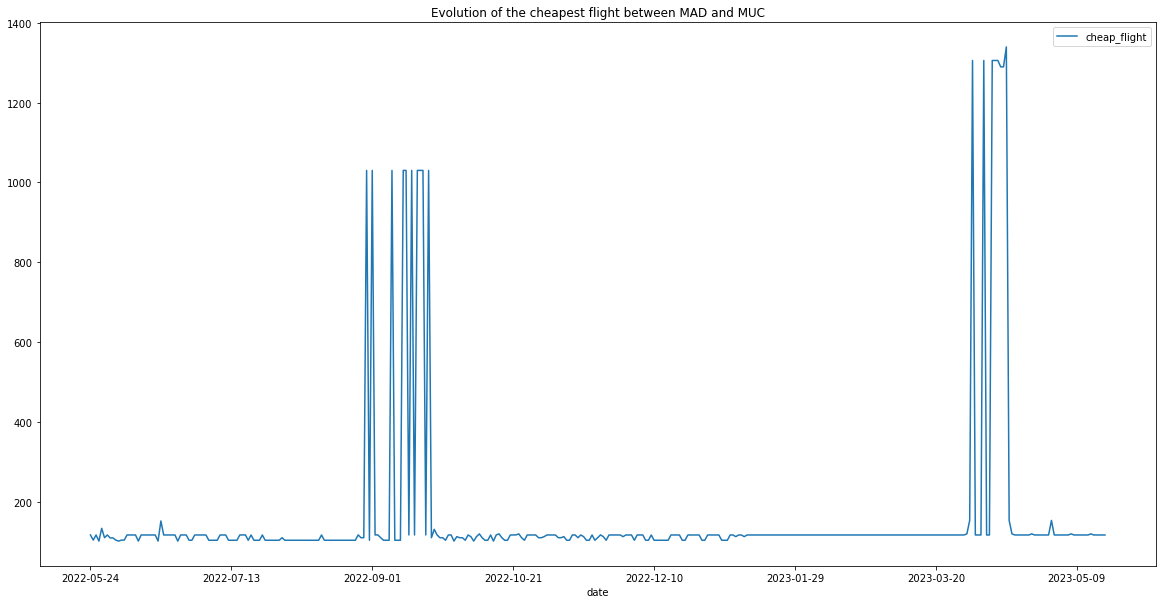

In [36]:
cheap_ts = spark\
            .read\
            .parquet('file:///media/data/cheap_flight.parquet')

cheap_ts_pd = cheap_td.toPandas().sort_values(by='date').astype({'cheap_flight': 'float'}).set_index('date')
cheap_ts_pd.plot(figsize = (20,10), title ="Evolution of the cheapest flight between MAD and MUC")